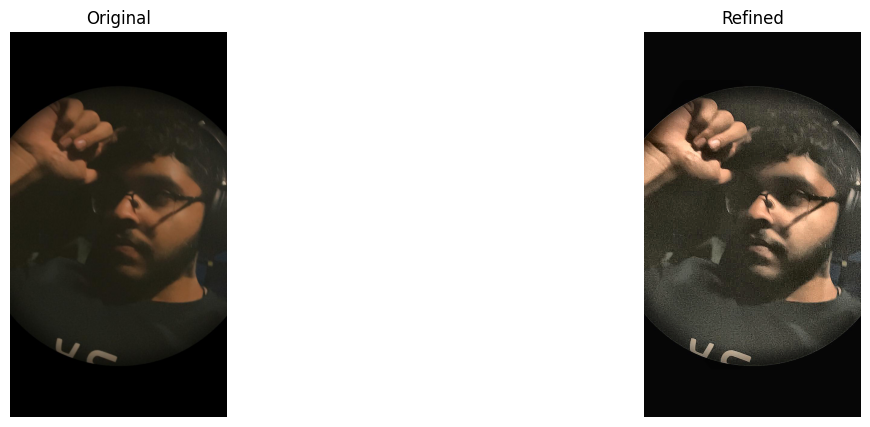

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle

def load_image(image_path):
    """Load an image from a file path."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image from {image_path}. Please check the file path and format.")
    return image

def display_images(images, titles):
    """Display images in a single figure."""
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

def denoise_image(image):
    """Apply Non-Local Means Denoising."""
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

def wiener_deconvolution(image, kernel, noise_var):
    """Apply Wiener Deconvolution on each channel separately to reduce blur."""
    restored_channels = []
    
    for i in range(3):  
        channel = image[:, :, i] / 255.0  
        
        # Perform Fourier Transform
        image_fft = np.fft.fft2(channel)
        kernel_fft = np.fft.fft2(kernel, s=channel.shape)
        kernel_fft_conj = np.conj(kernel_fft)
        
        # Calculate the Wiener filter
        wiener_filter = kernel_fft_conj / (kernel_fft * kernel_fft_conj + noise_var)
        restored_fft = wiener_filter * image_fft
        
        # Inverse Fourier Transform to get the channel back
        restored_channel = np.fft.ifft2(restored_fft)
        restored_channel = np.clip(np.abs(restored_channel), 0, 1)
        
        # Append the restored channel (scaled to [0, 255])
        restored_channels.append((restored_channel * 255).astype(np.uint8))
    
    # Merge the 3 channels back together
    restored_image = cv2.merge(restored_channels)
    return restored_image

def lucy_richardson_deconvolution(image, psf, iterations=30):
    """Apply Lucy-Richardson deconvolution on each channel separately."""
    estimate = np.copy(image).astype(np.float64)  

    for _ in range(iterations):
        for i in range(3): 
            channel = estimate[:, :, i] / 255.0  
            estimate_conv = cv2.filter2D(channel, -1, psf)
            relative_blur = (image[:, :, i] / 255.0) / (estimate_conv + 1e-8)
            estimate[:, :, i] *= cv2.filter2D(relative_blur, -1, psf[::-1, ::-1])

    return np.clip(estimate, 0, 255).astype(np.uint8)

def sharpen_image(image, sigma=1.0, strength=1.5):
    """Apply Gaussian Unsharp Mask for sharpening."""
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1 + strength, blurred, -strength, 0)
    return np.clip(sharpened, 0, 255).astype(np.uint8)

def enhance_color_and_sharpness(image):
    """Enhance the color and sharpness without affecting the color scheme."""

    if len(image.shape) == 2: 
        return image  

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l_channel, a_channel, b_channel = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_l = clahe.apply(l_channel)

  
    enhanced_lab = cv2.merge((enhanced_l, a_channel, b_channel))
    
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_Lab2BGR)
    
    return enhanced_image

def unblur_image(image, method='wiener'):
    """Unblur the image using different deconvolution methods and enhance it."""
    if method == 'wiener':
       
        kernel_size = 5
        kernel = cv2.getGaussianKernel(kernel_size, 1)
        kernel = np.outer(kernel, kernel)  

        noise_variance = 0.01

        denoised = denoise_image(image)

        restored_image = wiener_deconvolution(denoised, kernel, noise_variance)

    elif method == 'lucy':
        
        kernel_size = 5
        psf = cv2.getGaussianKernel(kernel_size, 1)
        psf = np.outer(psf, psf)
        
        restored_image = lucy_richardson_deconvolution(image, psf)

    else:
        raise ValueError(f"Unknown method: {method}")

    sharpened = sharpen_image(restored_image, sigma=1.0, strength=2.0)

    enhanced = enhance_color_and_sharpness(sharpened)

    return enhanced

def process_image(image_path, method='wiener'):
    try:
        image = load_image(image_path)
        
        refined_image = unblur_image(image, method=method)

        display_images([image, refined_image], 
                       ['Original', 'Refined'])
    except ValueError as e:
        print(e)


image_path = 'images/nibba.jpeg'  
process_image(image_path, method='lucy') 
